In [174]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers, pickle
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages

In [197]:
file_name_list = ["20231030_1", "20231030_2", "20231121", "20231205"]

In [198]:
base_path = "/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/" #"/Volumes/DATA/"
#file_name = "20231030_2"
#sphere_data = ["20231030/2/1",
#               "20231030/2/2",
#               "20231030/2/3",
#               "20231030/2/4",
#               "20231030/2/5",]

file_name = "20231205"
sphere_data = ["20231205/1/meas/1",
               "20231205/1/meas/2",]

In [199]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

In [200]:
print(data_list)

['/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_0.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_1.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_2.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_3.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_4.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_5.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_6.h5', '/Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmba

In [201]:
remake_files = True

cal_fac = 0.5e-6 ## m/V

m = 30e-15 ## mass in kg

nstep = 40
n = len(data_list)
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, int(n)+1)]

x_freq = 30 # Hz
y_freq = 70 # Hz
bw = 5 ## Hz

if(remake_files):
    nsegs = 2**6 ## number of segments to chop up for Welch's method
    cdat, attr, fhandle = bu.get_data(data_list[0])
    nps = int(len(cdat[:,0])/nsegs)


    files_to_use = data_list
    noise_arr = np.zeros((len(files_to_use), 2))
    time_arr = np.zeros(len(files_to_use))
    pressure_arr = np.zeros(len(files_to_use))
    
    #plt.figure(figsize=(8,6))
    for i,f in enumerate(files_to_use):

        if(i%100 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        cf, x_cpsd = sig.welch(cdat[:,0], fs=attr['Fsamp'], nperseg=nps)
        cf, y_cpsd = sig.welch(cdat[:,1], fs=attr['Fsamp'], nperseg=nps)

        x_fpts = (cf > x_freq-bw) & (cf < x_freq+bw)
        y_fpts = (cf > y_freq-bw) & (cf < y_freq+bw)

        time_arr[i] = attr['Time']
        pressure_arr[i] = attr['pressures'][0]
        
        med_x_noise = np.median(np.sqrt(x_cpsd[x_fpts])) * cal_fac * m * (2*np.pi*x_freq)**2
        med_y_noise = np.median(np.sqrt(y_cpsd[y_fpts])) * cal_fac * m * (2*np.pi*y_freq)**2
        noise_arr[i,:] = [med_x_noise, med_y_noise]

        if(False):
            plt.subplot(2,1,1)
            plt.semilogy(cf, np.sqrt(x_cpsd)*cal_fac, color=colors[i]) #, 'k')
            plt.ylabel("X PSD [m/$\sqrt{\mathrm{Hz}}$]")
            plt.xlim(0,200)
            plt.xlabel("Frequency [Hz]")

            plt.subplot(2,1,2)
            plt.semilogy(cf, np.sqrt(y_cpsd)*cal_fac, color=colors[i]) #, 'k')
            plt.ylabel("Y PSD [m/$\sqrt{\mathrm{Hz}}$]")
            plt.xlim(0,200)
            plt.xlabel("Frequency [Hz]")


        #time_arr -= time_arr[0]
        np.savez("data/noise/noise_data_%s.npz"%file_name, noise_arr=noise_arr, time_arr=time_arr, pressure_arr=pressure_arr)
        
else:
    npzfile = np.load("data/noise/noise_data_%s.npz"%file_name)
    noise_arr = npzfile['noise_arr']
    time_arr = npzfile['time_arr']
    pressure_arr = npzfile['pressure_arr']

time_arr = time_arr - time_arr[0]


working on file 0: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_0.h5
working on file 100: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_100.h5
working on file 200: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_200.h5
working on file 300: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_300.h5
working on file 400: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_400.h5
working on file 500: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas/1/LPmbar_xyzcool_500.h5
working on file 600: /Users/dcmoore/Yale University Dropbox/David Moore/uspheres/decay_analysis/noise_data/20231205/1/meas

In [215]:
bad_times_dict = {"20231030_1": [[11000, 17000], [30000, 46000], [54000, 80000]],
                  "20231030_2": [[100000, 110000], [145000, 160000]],
                  "20231121": [[10000, 20000], [270000, 380000]],
                  "20231205": [[100000, 200000]]}

norm_dict = {"20231030_1": [1, 1],
             "20231030_2": [0.75, 1],
             "20231121": [1, 1],
             "20231205": [1, 1]}

/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


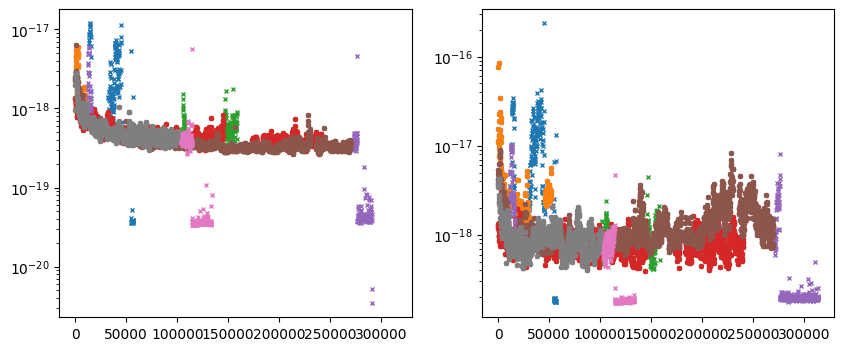

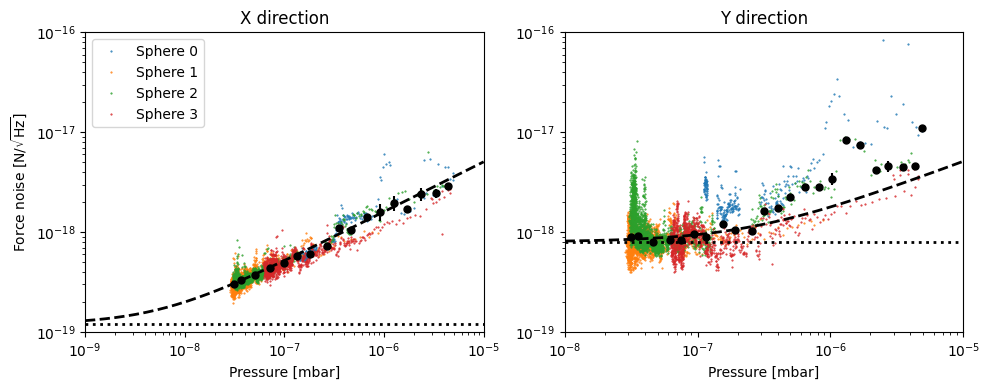

In [303]:
press_fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

time_fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

file_name_list = ["20231030_1", "20231030_2", "20231121", "20231205"]

tot_dat_x = []
tot_dat_y = []

for j, file_name in enumerate(file_name_list):

    norms = norm_dict[file_name]

    npzfile = np.load("data/noise/noise_data_%s.npz"%file_name)
    noise_arr = npzfile['noise_arr']
    time_arr = npzfile['time_arr']
    pressure_arr = npzfile['pressure_arr']

    time_arr = time_arr - time_arr[0]


    bad_times = bad_times_dict[file_name]


    gpts = np.ones_like(time_arr, dtype=bool)
    for bt in bad_times:
        gpts = gpts & ((time_arr < bt[0]) | (time_arr > bt[1]))


    plt.figure(press_fig.number)
    plt.subplot(1,2,1)
    plt.loglog(pressure_arr[gpts], noise_arr[gpts,0]*norms[0], 'o', ms=0.5, label="Sphere %d"%j)
    plt.ylim(1e-19, 1e-16)
    plt.subplot(1,2,2)
    plt.loglog(pressure_arr[gpts], noise_arr[gpts,1]*norms[1], 'o', ms=0.5)
    plt.ylim(1e-19, 1e-16)

    curr_vec = np.hstack( (np.array([pressure_arr[gpts]]).T, np.array(noise_arr[gpts,:]*norms[0])) )
    if(j==0):
        tot_dat_x = curr_vec
    else:
        tot_dat_x = np.vstack((tot_dat_x,curr_vec))

    curr_vec = np.hstack( (np.array([pressure_arr[gpts]]).T, np.array(noise_arr[gpts,:]*norms[1])) )
    if(j==0):
        tot_dat_y = curr_vec
    else:
        tot_dat_y = np.vstack((tot_dat_y,curr_vec))

    plt.figure(time_fig.number)
    plt.subplot(1,2,1)
    plt.semilogy(time_arr, noise_arr[:,0], 'x', ms=3, label="X")
    plt.semilogy(time_arr[gpts], noise_arr[gpts,0], 'o', ms=3, label="X")
    plt.subplot(1,2,2)
    plt.semilogy(time_arr, noise_arr[:,1], 'x', ms=3, label="Y")
    plt.semilogy(time_arr[gpts], noise_arr[gpts,1], 'o', ms=3, label="Y")


plt.figure(press_fig.number)
plt.subplot(1,2,1)
plt.legend(loc="upper left")
plt.xlabel("Pressure [mbar]")
plt.ylabel("Force noise [N/$\sqrt{\mathrm{Hz}}$]")
plt.title ("X direction")
plt.xlim(1e-9, 1e-5)

pvec = np.logspace(np.log10(1e-9), -5, 40)
noise_lev = 1.2e-19
noise_scale = 1.6e-15
plt.loglog(pvec, np.sqrt((noise_scale)**2*pvec + (noise_lev)**2), 'k--', lw=2)
plt.loglog(pvec, np.sqrt(0*pvec + (noise_lev)**2), 'k:', lw=2)
pvals = np.logspace(-9, -5, 30)
pcent = np.zeros(len(pvals)-1)
perr = np.zeros(len(pvals)-1)
ncent = np.zeros(len(pvals)-1)
for k in range(len(pvals)-1):
    curr_pts = (tot_dat_x[:,0] > pvals[k]) & (tot_dat_x[:,0] < pvals[k+1])
    ncent[k] = np.median(tot_dat_x[curr_pts,1])
    pcent[k] = np.median(tot_dat_x[curr_pts,0])
    perr[k] = np.std(tot_dat_x[curr_pts,1])/np.sqrt(np.sum(curr_pts))

plt.errorbar(pcent, ncent, yerr=perr, fmt='ko', ms=5)


plt.subplot(1,2,2)
plt.xlabel("Pressure [mbar]")
#plt.ylabel("Force noise [N/$\sqrt{\mathrm{Hz}}$]")
plt.title ("Y direction")
plt.xlim(1e-8, 1e-5)

pvec = np.logspace(np.log10(1e-8), -5, 80)
plt.loglog(pvec, np.sqrt((1.6e-15)**2*pvec + (8e-19)**2), 'k--', lw=2)
plt.loglog(pvec, np.sqrt(0*pvec + (8e-19)**2), 'k:', lw=2)
pvals = np.logspace(-8, -5, 30)
pcent = np.zeros(len(pvals)-1)
perr = np.zeros(len(pvals)-1)
ncent = np.zeros(len(pvals)-1)
for k in range(len(pvals)-1):
    curr_pts = (tot_dat_y[:,0] > pvals[k]) & (tot_dat_y[:,0] < pvals[k+1])
    ncent[k] = np.median(tot_dat_y[curr_pts,2])
    pcent[k] = np.median(tot_dat_y[curr_pts,0])
    perr[k] = np.std(tot_dat_y[curr_pts,1])/np.sqrt(np.sum(curr_pts))

plt.errorbar(pcent, ncent, yerr=perr, fmt='ko', ms=5)

plt.tight_layout()
plt.savefig("plots/noise_vs_pressure_compliation.pdf")

plt.show()